# Tracking the healing of a scared landscape...
***How can we use remote sensing and weather/climate data to monitor the recovery of vegetation ecosystems after geological resource extraction projects have closed?***

Project group members: Christian Haselwimmer

Project mentors: Nayani Ilangakoon (CU EarthLab), Steve Perkins (Chevron)

In [44]:
# Libraries and configuration that will be used in this blog post
import datetime
from datetime import date
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
import geopandas as gpd
from shapely.geometry import box
import earthpy.plot as ep
import rioxarray as rxr
from rasterio.plot import plotting_extent
import contextily as cx
import folium
from IPython.display import YouTubeVideo

from sentinelhub import SHConfig, WcsRequest, MimeType, CRS, BBox, CustomUrlParam

# SentinelHub configuration
config = SHConfig()

# Instance ID for AWS Europe endpoint
config.instance_id = 'e0d91a9e-9e07-4ba3-a274-4a261d555721'

# Credentials from the OAuth client
config.sh_client_id = '6b0f1254-59e8-4349-bcd3-6a56e3ea651e'
config.sh_client_secret = 'spD*%T/nPjY&/]45iXyYqEjvk_ulGn?PEHb/;};T'
config.save()

# Set working directory
os.chdir(os.path.join('E:',
                      'McKinley'))

FileNotFoundError: [WinError 2] The system cannot find the file specified: 'E:McKinley'

## 7.9 billion people need lots of geological resources!
The earth's population, especially the roughly 20% that live in the most developed countries, have significant demands for geological resources such as hydrocarbons, raw materials, minerals, and metals. Whilst we make strides in efforts to reduce these demands, for example through energy efficiency, closed loop supply chains, and decarbonisation, the projections for global population and development suggest that there will be continuing and increasing needs for geological resources.

## The environmental impact
The extraction of geological resources has an inevitable impact on the environment. Resource projects may have significant physical footprints where major earth-movement tasks are required (e.g. open-cast mining) or large surface facilities need to be constructed. This physical impact may lead to degradation, loss, or destruction of pre-development ecosystems and habitats. Responsible development of geological resources involves careful planning to minimize and mitigate the potential physical environmental impacts (air, water, soil, ecological) and accounting for ecosystem disturbance/loss through offsetting measures.


<img src="img/environmental.jpg" alt="Environmental impacts of geological resource extraction" style="width: 800px;"/>
<center>Examples of the physical environmental impact of geological resource extraction. Left: Kennecott copper mine in Utah (Source: Kennecott). Right: Kern River oil field in Calfornia (Source: Sierra Club)</center>

## Responsible closure
Closing facilities in a responsible way is fundamental to improving the sustainability of geological resource developments. Once a facility has reached the end of its life these sites must be returned to their pre-development or improved ecological condition. The process of retiring assets can include remediation of potential impacts to ecological receptors (e.g. soils and waters), reclamation and earth-movement to return the topography to a natural state, and ecological restoration such as vegetation re-establishment/re-seeding and/or elimination of invasive species.

## Restoring vegetation ecosystems
Vegetation restoration aims to repair the damage caused by land disturbance associated with resource extraction projects. It includes restoring the natural vegetation state and rebuild the soils of disturbed lands through either natural processes (plant succession) or man-made rewilding/reseeding efforts. The success of vegetation restoration efforts requires careful monitoring over many years to ensure that minimum thresholds are met with regards to vegetation cover, species makeup, function, and sustainability.

<img src="img/restoration.jpg" alt="Environmental impacts of geological resource extraction" style="width: 800px;"/>
<center>Example of responsible closure and vegetation restoration. Left: McKinley Mine open-pit coal mining operations. Right: the same location after reclamation and vegetation restoration</center>

## Getting a pulse on the state of vegetation restoration
Monitoring vegetation restoration projects typically requires detailed, time consuming, and in-frequent field surveys. Satellite remote sensing has potential to provide additional information to augment or replace these field methods. The synoptic coverage and cadence of satellite remote sensing could provide a capability for more timely monitoring of key vegetation parameters that when coupled with weather/climate data has potential to be used for restoration planning and decision making. In this project I will use remote sensing and climate data to monitor the trajectory and success of vegetation restoration measures at a specific legacy coal mining site (McKinley Mine) in New Mexico.

Previous work on the use of remote sensing has demonstrated....

## McKinley coal mine, New Mexico
The former McKinley open-pit coal mine is located in Western New Mexico near to the city of Gallup (see map below). This 28,000 acre site was operational up until 2009 (see the video below) after which the site was completely reclaimed and regraded. Currently the site is in various stages of vegetation restoration.

#### Video showing coal mining operations at McKinley Mine

In [ ]:
# Embed a video
YouTubeVideo('rBMTTxi7jb0', width=854, height=480)

#### Location map of McKinley Mine

C:\Users\ekqo\Miniconda3\envs\earth-analytics-python\lib\site-packages\contextily\tile.py:353: RasterioDeprecationWarning: Source dataset should be opened in read-only mode. Use of datasets opened in modes other than 'r' will be disallowed in a future version.
  img.transpose(2, 0, 1), transform, "EPSG:3857", t_crs, resampling


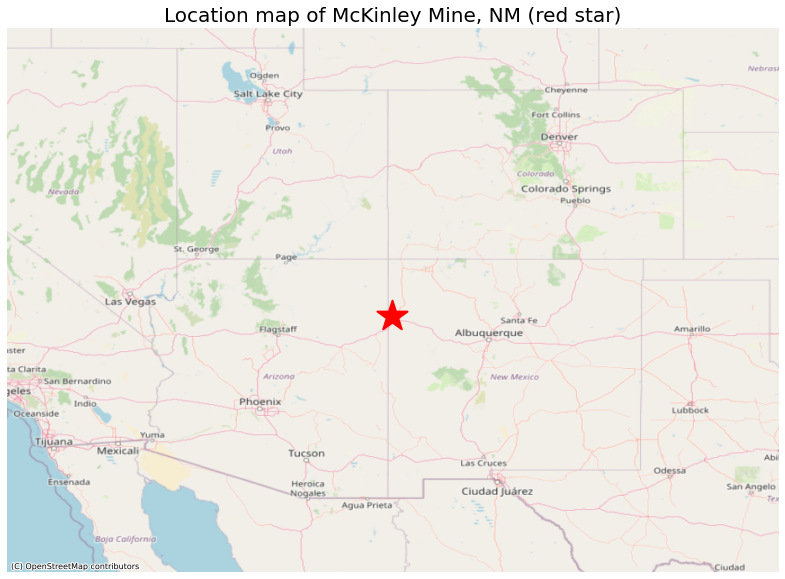

In [2]:
# Import polygon for extent of location map
mckinley_aoi_large_path = os.path.join(
    'vectors', 'mckinley_large_figure_bounds.shp')
mckinley_aoi_large = gpd.read_file(mckinley_aoi_large_path)

# Import point polygon for McKinley Mine location
mckinley_location_path = os.path.join(
    'vectors', 'mckinley_location.shp')
mckinley_location = gpd.read_file(mckinley_location_path)

# Plot location map
fig, (ax) = plt.subplots(1, 1, figsize=(15, 10))

xlim = ([mckinley_aoi_large.total_bounds[0],
         mckinley_aoi_large.total_bounds[2]])
ylim = ([mckinley_aoi_large.total_bounds[1],
         mckinley_aoi_large.total_bounds[3]])

ax.set_xlim(xlim)
ax.set_ylim(ylim)

mckinley_location.plot(ax=ax,
                       color='red',
                       marker='*',
                       markersize=1000,
                       linewidth=2
                       )

cx.add_basemap(ax, crs=mckinley_aoi_large.crs.to_string(),
               source=cx.providers.OpenStreetMap.Mapnik)

ax.set_title(
    "Location map of McKinley Mine, NM (red star)", fontsize=20)

ax.set_axis_off()

## Methods and results
### Overview
The general methods that I will be using for this project include:
- Accessing outlines of different vegetation management and seeding units at McKinley Mine that will be the basis for the remote sensing analysis
- Building a time series of remote sensing vegetation indices from Sentinel 2 and Landsat 8 data for 2013-present
- Extracting a time series of weather/climate data for 2013 to present
- Calculating relevant remote sensing (e.g. max annual NDVI) and weather/climate (e.g annual precipitation) metrics for the different vegetation management and seeding units
- Building statistical models using metrics to understand controlling variables

### Datasources
- Vector datasets will include polygons of vegetation management units and seeding units at McKinley Mine
- Sentinel 2 and Landsat 8 multispectral remote sensing data and time series analyses over the 2013 to current period will be accessed through SentinelHub (https://www.sentinel-hub.com/); the calculation of time series of vegetation indices including NDVI and SAVI will be performed using the Statistical Info Service (FIS) API (https://www.sentinel-hub.com/develop/api/ogc/fis-request/).
- Climate/weather data time series will be retrieved either from aWhere (https://www.awhere.com/) or from the GRIDMET (University of Idaho Gridded Surface Meteorological Dataset) accessible through Google Earth Engine (https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_GRIDMET) 

### Open vector data of Vegetation Management Units (VMU's) at McKinley Mine
VMU's represent areas of the mine that have undergone different histories of vegetation restoration measures. The time series of vegetation indices will be calculated for each VMU to account for the different phases of seeding. Let's start by opening and creating visualization of the VMU's.

In [42]:
# Import polygons for Vegetation Management Units (VMU's)
vmu_path = os.path.join('vectors',
                        'mckinley_vmu_mmd_osm.shp')
vmu_polys = gpd.read_file(vmu_path)
vmu_polys = vmu_polys.to_crs("EPSG:4326")

# Initialize a slippy map using the McKinley location xy
m = folium.Map(location=[float(mckinley_location.geometry.y[0]), float(
    mckinley_location.geometry.x[0])], zoom_start=12, tiles='CartoDB positron', titles='test')

# Iterate over polygons and add to slippy map with popups
for _, poly in vmu_polys.iterrows():
    poly_geo = gpd.GeoSeries(poly['geometry'])
    #sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
    poly_geoj = poly_geo.to_json()
    poly_geoj = folium.GeoJson(data=poly_geoj,
                               style_function=lambda x: {'fillColor': 'orange'})
    folium.Popup(poly['ID']).add_to(poly_geoj)
    poly_geoj.add_to(m)
m

### Querying SentinelHub to download and visualize a Sentinel 2 image from a single date
Let's start by accessing SentinelHub and finding the most recent Sentinel 2 data collected over the site and visualizing this with the VMU polygons.

In [ ]:
# # Import generalized McKinley Mine AOI
# mckinley_aoi_path = os.path.join(
#     'vectors', 'mckinley_aoi.shp')
# mckinley_aoi = gpd.read_file(mckinley_aoi_path)
# mckinley_aoi = mckinley_aoi.to_crs("EPSG:4326")

# # Import polygons for McKinley Mine boundary
# mckinley_outline_path = os.path.join('vectors',
#                                      'Boundaries.shp')
# mckinley_outline = gpd.read_file(mckinley_outline_path)
# mckinley_outline = mckinley_outline.to_crs("EPSG:4326")


### Setup bounding box for Sentinel 2 data search

In [ ]:
# Use the McKinley outline polygon to define a bounding box
AOI_coords_ndarray = mckinley_aoi.total_bounds.round(decimals=2)
AOI_coords = list(AOI_coords_ndarray)
AOI_bbox = BBox(bbox=AOI_coords, crs=CRS.WGS84)

### Query SentinelHub API for most recent Sentinel 2 data

In [ ]:
# Query SentinelHub to find available dates for the time window of interest
sentinel2_wcs_query = WcsRequest(layer='BANDS-S2-L2A',
                                 bbox=AOI_bbox,
                                 time=('2021-01-01', date.today()),
                                 maxcc=0.2,
                                 resx='20m', resy='20m',
                                 config=config)

# Print the available dates
for index, date in enumerate(sentinel2_wcs_query.get_dates()):
    print(' - image %d was taken on %s' % (index, date))

### Download Sentinel 2 data for a specific date

In [ ]:
# Location of data download folder
data_folder = r"E:\McKinley\sentinelhub_data"

# SentinelHub evaluation script to return all Sentinel 2 bands
sentinel2_allbands_script = 'return [B01, B02, B03, B04, B05, B06, B07, B08, B8A, B09, B11, B12]'

# Build the download WCS request
sentinel2_wcs_download = WcsRequest(layer='BANDS-S2-L2A',
                                    bbox=AOI_bbox,
                                    time=('2021-04-24', date.today()),
                                    maxcc=0.9,
                                    resx='20m', resy='20m',
                                    data_folder=data_folder,
                                    image_format=MimeType.TIFF,
                                    time_difference=datetime.timedelta(hours=48),
                                    custom_url_params={
                                        CustomUrlParam.EVALSCRIPT: sentinel2_allbands_script},
                                    config=config)

# Run the download request
sentinel2_wcs_download.save_data()

# Download list
downloads = sentinel2_wcs_download.get_filename_list()
downloads

### Open and plot the image

In [ ]:
# Open the dataset
sentinel2_data = rxr.open_rasterio(data_folder + "/" + downloads[0])

# Create plotting extent
image_extent = plotting_extent(sentinel2_data[0],
                               sentinel2_data.rio.transform())

# Setup figure
fig, (ax) = plt.subplots(1, 1, figsize=(25, 15))

ep.plot_rgb(sentinel2_data.values,
            rgb=[8, 4, 3],
            extent=image_extent,
            stretch=True,
            str_clip=0.5,
            ax=ax)

mckinley_outline.plot(ax=ax,
                      color='None',
                      edgecolor='red',
                      linewidth=4)

scalebar = ScaleBar(dx=111, units="km")
plt.gca().add_artist(scalebar)

ax.set_title(
    "False color composite of Sentinel 2 data over McKinley Mine from 2021-04-24", fontsize=20)

ax.text(.02, .02, "Source: SentinelHub", transform=ax.transAxes, color="white")

plt.show()